# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

#import os
#os.getcwd()
#azdias.to_csv('/home/workspace/Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

The cell below defines a function to treat the not available (NA) cells or missing values:
    - remove features with more than 20% of NA, this can also be done with dropna method
    - drop records with not available data 

In [3]:
def treat_NA(df, por_nas):
    """
    Remove features with por_nas % of NA and drop records with NA
    
    Input:
        df: pandas dataframe
        por_nas: maximun porcentage of NA that a feature must have to be romoved
        
    Output:
        df_new: pandas dataframe without NA
    """
    
    por_nas_cols = df.isna().sum(axis = 0) / df.shape[0] * 100
    new_cols = df.columns[por_nas_cols < por_nas] 
    try:
        new_cols = new_cols.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])
    except:
        pass
    df_nas = df[list(new_cols)]
    df_nas.dropna(inplace=True)
    
    # Unknown classes treatment
    #por_nas_cols = np.sum(c_nas.iloc[:,:] == -1, axis = 0) / c_nas.shape[0] * 100
    #new_cols = c_nas.columns[por_nas_cols > 20] 
    
    print('--- Treating NA in pandas dataframe ---')
    print('Shape of dataframe after NA treatment: ', df.shape)
    print('Shape of dataframe before NA treatment: ', df_nas.shape)
    print('\nNumber of features removed: ', df.shape[1]-df_nas.shape[1])
    print('Percentage of records removed: ', round((df.shape[0]-df_nas.shape[0])/df.shape[0]*100, 2), '%')
    
    return df_nas

c_nas = treat_NA(customers, 20)

--- Treating NA in pandas dataframe ---
Shape of dataframe after NA treatment:  (191652, 369)
Shape of dataframe before NA treatment:  (185560, 113)

Number of features removed:  256
Percentage of records removed:  3.18 %


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The cell below defines a function that first transforms categorical variables into dummies and second standardize the numerical features

In [4]:
def dummies_and_scale(df_nas):
    """
    Transform categorical features and standardize numerical ones
    
    Input:
        df_nas: dataframe without NA
        
    Output:
        df_dummies: dataframe without categorical features 
        df_scaled: dataframe without categorical features and standardize 
    """
    
    df_dummies = pd.get_dummies(df_nas) 
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_dummies.astype(float)))
    df_scaled.columns = df_dummies.columns
    df_scaled.index = df_dummies.index

    print('--- Creating dummies and standardizing ---')
    print('Number of dummies variables created: ', df_dummies.shape[1]-df_nas.shape[1])
    print('Number of scaled features: ', df_scaled.shape[1])
    return df_dummies, df_scaled

c_dummies, c_scaled = dummies_and_scale(c_nas)

--- Creating dummies and standardizing ---
Number of dummies variables created:  0
Number of scaled features:  113


The next cells are related to feature selection, which is an important step before doing exploratory analysis or any other. The different methods that I propose are explianed in the report.pdf. I propose three methods:
    - Principal component analysis (PCA)
    - Sparse PCA
    - Logistic regression
    
So, the first thing before finding the most representative features of the dataset is implementing functions for PCA, SparsePCA and logistic regression.

In [5]:
def PCA_decomposition(df_scaled, n_pca, method):
    """
    This function creates n_pca number of principal components of a given dataset.
    
    Input:
        df_cleaned: dataframe without categorical features and standardize 
        n_pca: number of components
        method: 'PCA' or 'SparsePCA'
        
    Output:
        loadings: the transformation matrix from dr_cleaned to the new variables
        df_pcas: the new dataframe   
    """
    
    pca = PCA(n_components = n_pca)
    pca.fit(df_scaled)
    por_exp = round(np.sum(pca.explained_variance_ratio_), 2)
    
    if method == 'SparsePCA':
        pca = SparsePCA(n_components = n_pca)
        pca.fit(df_scaled)
        
    loadings = pca.components_
    df_pcas = pd.DataFrame(np.matmul(df_scaled, np.transpose(pca.components_)))
    
    print('--- Creating PCAs ---')
    print('Number of principal components created: ', n_pca)
    print('Porcentage of the total variance explained: ', por_exp, '%')
    return loadings, df_pcas

c_loading, c_df_pcas = PCA_decomposition(c_scaled, 25, 'PCA')
c_loadingS, c_df_Spcas = PCA_decomposition(c_scaled, 3, 'SparsePCA')

--- Creating PCAs ---
Number of principal components created:  25
Porcentage of the total variance explained:  0.77 %
--- Creating PCAs ---
Number of principal components created:  3
Porcentage of the total variance explained:  0.46 %


In [6]:
def logit_reg(y, X):
    """
    Fit a logistic model.
    
    Input:
        y: response variable
        X: explanatory variables
        
    Output: estimation parameters
        
    """
    
    
    clf = LogisticRegression().fit(X, y)
    return clf, clf.coef_
    
y = customers['ONLINE_PURCHASE'][list(c_scaled.index)]
X = c_scaled
c_clf, c_coefs = logit_reg(y, X)

In [7]:
def select_features(sort_dict, features, n_importance):
    """
    Given the importance of each feature this function returns the n_importance number of them
    
    Input:
        sort_dict: dictionary containing the importance of each feature
        features: list of features
        n_imoprtance: number of features to be choosen
        
    Output: return the most important features
    """
    
    aux = dict(enumerate(abs(sort_dict[0])))
    aux_sort = {k: v for k, v in sorted(aux.items(), key=lambda item: item[1])}    
    cols = features[list(aux_sort.keys())[-n_importance:]]
    print(list(reversed(cols.tolist())))
    return list(reversed(cols.tolist()))

In [297]:
cols_pca = select_features(c_loading, c_scaled.columns, 5) # [69, 37, 109, 73, 107] 
cols_spca = select_features(c_loadingS, c_scaled.columns, 5)  # [12, 17, 16, 59, 51]
cols_logit = select_features(c_coefs, c_scaled.columns, 5) # [90, 95, 59, 7, 74]
selected_cols = np.unique(cols_pca + cols_spca + cols_logit).tolist()

['FINANZ_ANLEGER', 'D19_KONSUMTYP_MAX', 'VERS_TYP', 'FINANZ_UNAUFFAELLIGER', 'SEMIO_VERT']
['D19_BANKEN_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_TELKO_OFFLINE_DATUM']
['CJT_TYP_4', 'CJT_TYP_3', 'CJT_TYP_1', 'CJT_KATALOGNUTZER', 'CJT_TYP_6']


Once we have found the most relevant features of the customers dataset, an exploratory analysis can be done. For example, correlation between the selected features is a good start, since high correlated features must be removed. also, a percentage of correlation per feature is displayed as a resume of the matrix.

In [9]:
c_cleaned_s = c_dummies[selected_cols]
cors = c_cleaned_s.corr()
abs(cors)
abs(cors).sum(axis=1) / cors.shape[0] * 100

ALTERSKATEGORIE_GROB        42.558171
D19_BANKEN_DATUM            34.691026
D19_BANKEN_OFFLINE_DATUM    22.495457
D19_BANKEN_ONLINE_DATUM     26.836234
D19_GESAMT_ANZ_12           42.351565
D19_KONSUMTYP_MAX           53.777987
D19_TELKO_OFFLINE_DATUM     23.460476
D19_VERSAND_ONLINE_DATUM    40.358096
FINANZ_ANLEGER              49.215798
FINANZ_UNAUFFAELLIGER       48.790627
KOMBIALTER                  56.616979
PRAEGENDE_JUGENDJAHRE       42.302381
SEMIO_VERT                  48.402437
VERS_TYP                    53.359115
dtype: float64

The next cell creates histograms for every selected feature, from ind = 0 to ind = 13 (14 features). It also prints unique values per feature. Finally, a descriptive statistics summary is depicted for those customers that purchase online.

Unique values in KOMBIALTER are: [1 2 3 4 9]


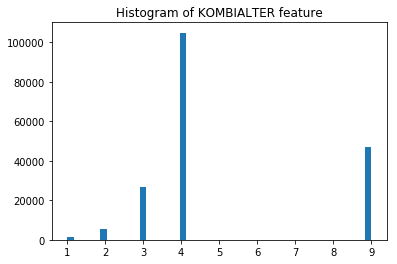

In [10]:
ind = 10
uniques_col = np.unique(c_cleaned_s.iloc[:,ind]) 
print('Unique values in', selected_cols[ind], 'are:', uniques_col)
plt.hist(c_cleaned_s.iloc[:,ind], bins='auto')
plt.title('Histogram of ' + selected_cols[ind] + ' feature')
plt.show()

In [11]:
#y.sum() / y.shape[0] * 100
c_cleaned_s_1 = c_cleaned_s[y == 1]
c_cleaned_s_1.describe().round().iloc[:,:5]
y[c_cleaned_s.iloc[:,ind] == 4].sum() / y.sum()*100

29.552274636898328

After exploratory analysis is done clustering for the customers dataset is the next step. First, we must choose a good numbre of clusters, k. That is, finding a good trade off between inertia (sum of errors per cluster) and k. For this purpose, the graph below is very useful. A good k is when erros stops decreasing. In this case, k = 30 would be a good option in term of error but not in terms of efficiency computing or interpretability, so k = 5 is choosen.

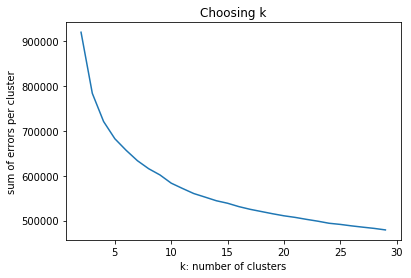

In [10]:
avg = []
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(c_scaled)
    avg.append(kmeans.inertia_)
    
plt.plot(range(2,30), avg)
plt.title('Choosing k')
plt.xlabel('k: number of clusters')
plt.ylabel('sum of errors per cluster')
plt.show()

Now that a good option for the number of clusters (k) have been found, it is time to create a function that given a dataset an k performs k-means clustering. After this, differences between the representative columns ONLINE_PURCHASE, PRODUCT_GROUP and CUSTOMER_GROUP are found. This is done creating a dataframe where each row is a cluster and the columns are the % of each of the clases of the previous columns. Finally, it can be observed that by ordering the last column the other columns are in crescent order too.

In [12]:
# np.unique(customers['ONLINE_PURCHASE']) # [0, 1]
# np.unique(customers['PRODUCT_GROUP']) # ['COSMETIC', 'COSMETIC_AND_FOOD', 'FOOD']
# np.unique(customers['CUSTOMER_GROUP']) # ['MULTI_BUYER', 'SINGLE_BUYER']

def k_means(df_scaled, k):
    """
    Perform k-means clustering
    
    Input: 
        df_scaled: dataframe without categorical features and standardize 
        k: number of clusters
        
    Output:
        
    """

    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_scaled)
    labels = kmeans.labels_
    
    return kmeans, labels

k = 5
kmeans, labels = k_means(c_scaled, k)

In [13]:
n_records = c_scaled.shape[0]
values = []
for cluster in range(k):
    index = labels == cluster
    op_1 = round(np.sum(customers['ONLINE_PURCHASE'][index]) / n_records * 100, 2)
    op_0 = 100 - op_1
    
    pg_cosmetic = round(np.sum(customers['PRODUCT_GROUP'][index] == 'COSMETIC') / n_records * 100, 2)
    pg_cosmetic_food = round(np.sum(customers['PRODUCT_GROUP'][index] == 'COSMETIC_AND_FOOD') / n_records * 100, 2)
    pg_food = 100 - pg_cosmetic - pg_cosmetic_food
    
    cg_multibuyer = round(np.sum(customers['CUSTOMER_GROUP'][index] == 'MULTI_BUYER') / n_records * 100, 2)
    cg_singlebuyer = 100 - cg_multibuyer
    
    aux = [op_1, op_0, pg_cosmetic, pg_cosmetic_food, pg_food, cg_multibuyer, cg_singlebuyer]
    values.append(aux)
    
cols = ['op_1', 'op_0', 'pg_cosmetic', 'pg_cosmetic_food', 'pg_food', 'cg_multibuyer', 'cg_singlebuyer']
df = pd.DataFrame(values, index = range(k), columns = cols)
df.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/internals.py:312: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 191652 but corresponding boolean dimension is 185560
  return self.values[slicer]
/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/base.py:2095: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 191652 but corresponding boolean dimension is 185560
  result = getitem(key)


,op_1,op_0,pg_cosmetic,pg_cosmetic_food,pg_food,cg_multibuyer,cg_singlebuyer
0,2.33,97.67,5.79,13.29,80.92,17.50,82.50
1,1.93,98.07,4.86,11.34,83.80,14.80,85.20
2,1.40,98.60,3.56,8.42,88.02,11.01,88.99
3,2.40,97.60,5.98,13.90,80.12,18.25,81.75
4,0.96,99.04,2.45,5.71,91.84,7.51,92.49


In [14]:
df.sort_values('cg_singlebuyer')

,op_1,op_0,pg_cosmetic,pg_cosmetic_food,pg_food,cg_multibuyer,cg_singlebuyer
3,2.40,97.60,5.98,13.90,80.12,18.25,81.75
0,2.33,97.67,5.79,13.29,80.92,17.50,82.50
1,1.93,98.07,4.86,11.34,83.80,14.80,85.20
2,1.40,98.60,3.56,8.42,88.02,11.01,88.99
4,0.96,99.04,2.45,5.71,91.84,7.51,92.49


To finish the part of unsupervised learning, the dataset azdias must be used. This dataset is very useful to find citizens of germany that would be good targets of a marketing campaign. That is, those citizens that are closer to the cluster center number 3 (the cluster with highest online purchase percentage). We can find the closest one with the method transform.

In [47]:
a = azdias[c_scaled.columns]
a_nas = treat_NA(a, 100)
a_dummies, a_scaled = dummies_and_scale(a_nas)

--- Treating NA in pandas dataframe ---
Shape of dataframe after NA treatment:  (891221, 113)
Shape of dataframe before NA treatment:  (868119, 113)

Number of features removed:  0
Percentage of records removed:  2.59 %
--- Creating dummies and standardizing ---
Number of dummies variables created:  0
Number of scaled features:  113


In [59]:
a_closer = np.transpose(kmeans.transform(a_scaled))
aux = dict(enumerate(abs(a_closer[3])))
aux_sort = {k: v for k, v in sorted(aux.items(), key=lambda item: item[1])}    
campaign_target_citizens_index = list(aux_sort.keys())[-3000:]

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [15]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Given that the train dataset is imbalanced in the response variable, a little exploratory analysis is done in each of the clusters:
    - percentage of 1's per cluster
    - distribution of 1's per cluster
    - percentage of records per cluster

In [298]:
cols = c_scaled.columns.tolist() ; cols.append('RESPONSE')
train_descriptive = mailout_train[cols]
train_descriptive_nas = treat_NA(train_descriptive, 100)
train_descriptive_dummies, train_descriptive_scaled = dummies_and_scale(train_descriptive_nas)

--- Treating NA in pandas dataframe ---
Shape of dataframe after NA treatment:  (42962, 114)
Shape of dataframe before NA treatment:  (41671, 114)

Number of features removed:  0
Percentage of records removed:  3.0 %
--- Creating dummies and standardizing ---
Number of dummies variables created:  0
Number of scaled features:  114


In [299]:
train_clusters = kmeans.predict(train_descriptive_scaled.drop('RESPONSE', axis=1))
n_responses = np.sum(train_descriptive_scaled['RESPONSE'] == 1)
for cluster in range(k):
    index = train_clusters == cluster
    por_resp_cluster = round(np.sum(train_descriptive_scaled['RESPONSE'][index]) / np.sum(index) * 100, 2) # % of 1's per cluster
    por_re_c = round(np.sum(train_descriptive_scaled['RESPONSE'][index]) / n_responses * 100, 2) # % Distribution of 1's per cluster
    por_1_cluster = round(np.sum(index) / train_clusters.shape[0] * 100, 2) # % of records in each cluster
    
    if cluster == 4:
        train_cluster = train_descriptive_scaled.iloc[index,:]
    print(cluster, por_resp_cluster, por_re_c, por_1_cluster)
    

0 1.18 16.18 17.09
1 1.27 16.57 16.29
2 1.32 35.07 33.04
3 1.44 24.47 21.12
4 0.77 7.71 12.46


Three different training datasets are considered:
    - The mailout_train dataset preprocessed (train_scaled)
    - The mailout_train clusterized (train_cluster)
    - The mailout_train balanced (train_scaled_balanced)
    
After this, stratified subsets for training, validation and testing are created.

In [300]:
train_cols = selected_cols
train_cols.append('RESPONSE')
train = mailout_train[train_cols]
train_nas = treat_NA(train, 100)
train_dummies, train_scaled = dummies_and_scale(train_nas)

--- Treating NA in pandas dataframe ---
Shape of dataframe after NA treatment:  (42962, 16)
Shape of dataframe before NA treatment:  (42357, 16)

Number of features removed:  0
Percentage of records removed:  1.41 %
--- Creating dummies and standardizing ---
Number of dummies variables created:  0
Number of scaled features:  16


In [301]:
train_scaled_remove_0 = train_scaled.iloc[:40000,:]
index = train_scaled_remove_0[train_scaled_remove_0['RESPONSE'] == 0].index
train_scaled_remove_0.drop(index, axis=0, inplace=True)

train_scaled_balanced = pd.concat([train_scaled_remove_0, train_scaled.iloc[40000:,:]], axis=0)
balanced_1 = np.sum(train_scaled_balanced['RESPONSE']  == 1) / train_scaled_balanced.shape[0] * 100
print('Old percentage of 1s is:', train_scaled['RESPONSE'].sum() / train_scaled.shape[0] * 100 , '%')
print('New percentage of 1s is:', balanced_1, '%')

Old percentage of 1s is: 1.24418632103 %
New percentage of 1s is: 18.5498064062 %


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [308]:
from sklearn.model_selection import train_test_split

#train_total = train_cluster[train_cols] 
train_total = train_scaled 
#train_total = train_scaled_balanced

y = train_total['RESPONSE']
X = train_total.drop('RESPONSE', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
 

Next three cells define the neccesary parts of a neural network:
    - Data loaders for training, validation and testing
    - Class defining the net configuration
    - Training function

In [309]:
import os
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

train_target = torch.tensor(y_train.values.astype(np.float32))
train = torch.tensor(X_train.values.astype(np.float32)) 
train_tensor = torch.utils.data.TensorDataset(train, train_target) 
train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, \
                                           num_workers=num_workers, shuffle=True)

valid_target = torch.tensor(y_valid.values.astype(np.float32))
valid = torch.tensor(X_valid.values.astype(np.float32)) 
valid_tensor = torch.utils.data.TensorDataset(valid, valid_target) 
valid_loader = torch.utils.data.DataLoader(dataset = valid_tensor, batch_size = batch_size, \
                                           num_workers=num_workers, shuffle=True)

test_target = torch.tensor(y_test.values.astype(np.float32))
test = torch.tensor(X_test.values.astype(np.float32)) 
test_tensor = torch.utils.data.TensorDataset(test, test_target) 
test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, \
                                           num_workers=num_workers, shuffle=True)

In [310]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

class BinaryClassifier(nn.Module):
    """
    Define a neural network that performs binary classification.
    The network accept  number of features as input, and produce 
    a single sigmoid value, that can be rounded to a label: 0 or 1, as output.
    """

    def __init__(self, input_features, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        """
        Initialize the model by setting up linear layers.
        Use the input parameters to help define the layers of your model.
        :param input_features: the number of input features in your training/test data
        :param hidden_dim: helps define the number of nodes in the hidden layer(s)
        :param output_dim: the number of outputs you want to produce
        """
        super(BinaryClassifier, self).__init__()
        # define any initial layers
        self.fc1 = nn.Linear(input_features, hidden_dim1)
        self.fc11 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc12 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc2 = nn.Linear(hidden_dim3, output_dim)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        
    
    ## TODO: Define the feedforward behavior of the network
    def forward(self, x):
        """
        Perform a forward pass of our model on input features, x.
        :param x: A batch of input features of size (batch_size, input_features)
        :return: A single, sigmoid-activated value as output
        """
        
        # define the feedforward behavior
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc11(x))
        x = self.dropout(x)
        x = F.relu(self.fc12(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer
        x = self.fc2(x)
        
        return torch.sigmoid(x) # apply sigmoid activation function

In [305]:
def train_(n_epochs, loaders, model, optimizer, criterion, use_cuda):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    train_l, valid_l = [], []
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            #train_loss += loss.data*data.size(0)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            #valid_loss += loss.item()*data.size(0)
            
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        train_l.append(train_loss) ; valid_l.append(valid_loss)
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss   
            
    # return trained model
    return model, train_l, valid_l

The next cell trains the model for a given number of epochs, learning rate and net configuration. If GPU power is available it will be used. Because this is a binary classification the binary cross entropy loss is considered (BCELoss). A plot of the training and validation loss along the epochs is done.

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: 1 	Training Loss: 0.099070 	Validation Loss: 0.067112
Validation loss decreased (inf --> 0.067112).  Saving model ...
Epoch: 2 	Training Loss: 0.069595 	Validation Loss: 0.066353
Validation loss decreased (0.067112 --> 0.066353).  Saving model ...
Epoch: 3 	Training Loss: 0.068309 	Validation Loss: 0.065549
Validation loss decreased (0.066353 --> 0.065549).  Saving model ...
Epoch: 4 	Training Loss: 0.067983 	Validation Loss: 0.065607
Epoch: 5 	Training Loss: 0.067648 	Validation Loss: 0.065275
Validation loss decreased (0.065549 --> 0.065275).  Saving model ...
Epoch: 6 	Training Loss: 0.067054 	Validation Loss: 0.065228
Validation loss decreased (0.065275 --> 0.065228).  Saving model ...
Epoch: 7 	Training Loss: 0.067846 	Validation Loss: 0.065198
Validation loss decreased (0.065228 --> 0.065198).  Saving model ...
Epoch: 8 	Training Loss: 0.067969 	Validation Loss: 0.066130
Epoch: 9 	Training Loss: 0.066949 	Validation Loss: 0.065252
Epoch: 10 	Training Loss: 0.066755 	Valida

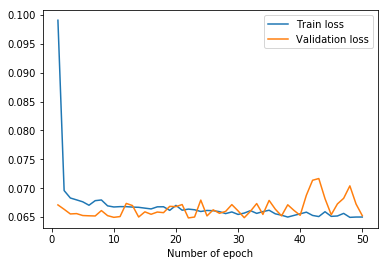

In [311]:
use_cuda = torch.cuda.is_available()
loaders = {}
loaders['train'] = train_loader
loaders['valid'] = valid_loader
model = BinaryClassifier(15, 300, 50, 300, 1)
#model = BinaryClassifier(14, 300, 1)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()
epochs = 50
model_scratch, train_l, valid_l = train_(epochs, loaders, model, optimizer, criterion, use_cuda)

plt.plot(range(1,epochs+1), train_l)
plt.plot(range(1,epochs+1), valid_l)
plt.xlabel('Number of epoch')
plt.legend(['Train loss', 'Validation loss'])
plt.show()

The next cell performs the area under the curve (AUC) metric for the model trained in the test dataset. The closest this metric is to 1 the best the model trained is.

In [312]:
from sklearn import metrics
y = test_target.detach().numpy()
pred = model_scratch(test).detach().numpy() 
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
auc = metrics.auc(fpr, tpr)
print('AUC metric of the neural network is: ', auc)

AUC metric of the neural network is:  0.685370531624


The benchmark model is trained and tested in the next cell.

In [214]:
y = train_target.detach().numpy()
X = train.detach().numpy()
c_clf, c_coefs = logit_reg(y, X)

y = test_target.detach().numpy()
pred = c_clf.predict(test)
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
auc = metrics.auc(fpr, tpr)
print('AUC metric of the logistic regression is: ', auc)

AUC metric of the logistic regression is:  0.5


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [215]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [226]:
test_k = mailout_test[selected_cols]
test_k_nas = treat_NA(test_k, 100)
test_k_dummies, test_k_scaled = dummies_and_scale(test_k_nas)

--- Treating NA in pandas dataframe ---
Shape of dataframe after NA treatment:  (42833, 14)
Shape of dataframe before NA treatment:  (42255, 14)

Number of features removed:  0
Percentage of records removed:  1.35 %
--- Creating dummies and standardizing ---
Number of dummies variables created:  0
Number of scaled features:  14


In [247]:
df_kaggle = pd.DataFrame(mailout_test['LNR'][test_k_scaled.index])

In [234]:
test_k_scaled_t = torch.tensor(test_k_scaled.values.astype(np.float32)) 
responses = model_scratch(test_k_scaled_t).detach().numpy()

In [250]:
df_kaggle['RESPONSE'] = responses

In [253]:
df_kaggle.to_csv('kaggle_test_responses.csv', sep=';')

In [256]:
df_kaggle.columns

Index(['LNR', 'RESPONSES'], dtype='object')